In [15]:
import pandas as pd
import numpy as np
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
import shap
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import random
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.decomposition import NMF, PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import Lasso
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import LeaveOneOut
from sklearn.feature_selection import f_classif, SelectFdr, SelectPercentile, SelectFwe
from scipy import stats

random_seed = 42

In [18]:
# Get combined data for training from utility function
os.chdir("..")
from ccrcc_preprocessing import preprocessed_data
df = preprocessed_data()

In [132]:
glycoform_df = df.iloc[:,1:10815]
glycoform_df

,LAMA5_222_IVPLENGEIVVSLVNGRPGAMnFSYSPLLR_251_22_N4H5F1S0G0,ITIH2_113_GAFISnFSMTVDGK_126_6_N4H5F0S1G0,APMAP_196_nMSFVNDLTVTQDGRK_211_1_N2H8F0S0G0,FN1_535_HEEGHMLnCTCFGQGR_550_8_N4H5F0S1G0,CD109_286_InGSANFSFNDEEMK_300_2_N2H8F0S0G0,PLXNB2_1031_EAESLQPMTVVGTDYVFHnDTK_1052_19_N5H5F1S0G0,CTSC_51_DVnCSVMGPQEK_62_3_N4H6F0S0G0,FGB_375_YRGTAGNALMDGASQLMGEnR_395_20_N4H5F0S1G0,CLU_97_ELPGVCnETMMALWEECKPCLK_118_7_N4H5F0S2G0,P4HA1_105_DMSDGFISnLTIQR_118_9_N2H6F0S0G0,...,LAMP1_255_LLNINPnK_262_7_N5H5F1S0G0,BTD_340_NPVGLIGAEnATGETDPSHSK_360_10_N2H5F0S0G0,GNS_356_GPGIKPnQTSK_366_7_N2H5F0S0G0,SERPINA1_64_QLAHQSnSTNIFFSPVSIATAFAMLSLGTK_93_7_N5H5F0S2G0,OLFML3_169_IYVLDGTQnDTAFVFPR_185_9_N4H5F1S0G0,FGG_65_DLQSLEDILHQVEnK_79_14_N5H6F1S1G0,LAMA5_3244_LLLGGLPESGTIYnFSGCISNVFVQR_3269_14_N3H5F0S1G0,CDH6_394_EDAQInTTIGSVTAQDPDAAR_414_6_N5H5F2S0G0,STAB1_1726_RnVTAAAQGFGYK_1738_2_N2H8F0S0G0,TFRC_242_DFEDLYTPVnGSIVIVR_258_10_N5H5F1S2G0
0,15.414611,17.194097,16.141039,14.363901,16.823150,14.832855,13.056170,16.359029,17.979474,16.248994,...,17.172884,15.595219,16.896178,14.772900,17.009510,17.000630,14.867106,16.117845,14.476855,13.869988
1,15.471691,17.326459,16.635474,14.500603,17.325074,14.425776,12.412877,16.231234,17.220815,17.775143,...,16.708616,14.813011,17.535315,14.475654,16.276239,16.769055,15.014174,15.494352,17.058441,15.707804
2,15.141840,17.161645,16.457631,14.414845,16.708205,14.883942,13.579303,15.945842,17.658734,16.499878,...,17.411223,15.522371,17.969214,14.031730,17.223192,15.992055,14.887579,16.258365,14.707436,13.973556
3,15.609682,17.531468,17.102947,14.800264,18.149726,14.342608,12.847752,16.093940,17.740037,17.990332,...,16.914639,14.863810,15.893730,14.174981,16.085713,16.342642,14.392180,15.445131,16.038721,13.995085
4,15.715771,18.490422,16.398802,15.219195,16.910034,14.234945,12.150975,15.950968,16.888709,17.698439,...,16.595294,14.752897,15.085696,14.938215,16.071357,16.330280,14.883073,15.729901,15.136480,14.661459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,15.604792,17.712529,15.843208,14.641417,17.100007,14.741740,11.287389,15.585231,17.039707,17.340122,...,16.114529,14.751935,15.918554,15.282739,16.357851,16.263307,15.353862,15.329724,16.139644,13.847798
179,16.211603,17.954562,16.001401,14.935134,16.855874,14.341116,11.059163,15.455444,17.018237,17.432247,...,16.396713,14.944425,17.023322,14.283089,17.317535,15.409376,14.876406,15.053775,15.552114,14.180602
180,15.304437,17.892701,15.250424,15.268693,17.133722,14.606062,14.117903,16.026908,18.260688,16.242812,...,17.171235,15.755052,17.782899,14.774031,17.353575,15.470574,15.692505,15.718774,14.379797,13.688188
181,16.095162,18.296734,15.964142,14.425399,17.198116,15.357927,11.403616,15.502065,16.530029,17.593074,...,17.462159,14.596866,15.774534,15.081243,16.642350,16.043253,14.897740,15.759281,15.647152,14.429359


## All Glycoforms

In [133]:
def get_glycoforms():

    site_dict = {}

    for i in glycoform_df.columns:
        row = i.split("_")
        gene, pep_start, sequence, gly_site, glycan = row[0], int(row[1]), row[2], int(row[4]), row[5]
        glycosylation_site = pep_start + gly_site - 1
    
        glycosite = gene + "_" + str(glycosylation_site) + "_" + sequence + "_" + glycan

        site_dict[i] = glycosite

    df_dict = {}

    for key,value in site_dict.items():
        df_dict[value] = glycoform_df[key]


    return pd.DataFrame(df_dict)

## Glycosites

In [134]:
def get_glycosites():

    df_all_glycoforms = get_glycoforms()

    site_dict = {}

    for i in df_all_glycoforms.columns:
        row = i.split("_")
        gene, gly_site, peptide, glycan = row[0], row[1], row[2], row[3]
    
        glycosite = gene + "_" + gly_site

        if glycosite not in site_dict:
            site_dict[glycosite] = [i]
        
        else: 
            site_dict[glycosite].append(i)

    df_dict = {}

    for key,value in site_dict.items():
        if len(value) == 0:
            continue
        df_dict[key] = df_all_glycoforms[value].sum(axis=1)


    return pd.DataFrame(df_dict)

## Glycosite with type

In [135]:
def get_glycotype():

    df_all_glycoforms = get_glycoforms()

    site_dict = {}

    for i in df_all_glycoforms.columns:
        row = i.split("_")
        gene, gly_site, peptide, glycan = row[0], row[1], row[2], row[3]
    
        glycosite = gene + "_" + gly_site

        if glycosite not in site_dict:

            site_dict[glycosite] = [] # keep this row
            site_dict[glycosite+'_fucosylated'] = []
            site_dict[glycosite+'_sialylated-no-fuc'] = []
            site_dict[glycosite+'_highmannose'] = []
            site_dict[glycosite+'_complex-asialyl-no-fuc'] = []
    
        if "F0" not in glycan: site_dict[glycosite+'_fucosylated'].append(i)
        elif "S0" not in glycan: site_dict[glycosite+'_sialylated-no-fuc'].append(i)
        else:
            if "N2" in glycan: 
                site_dict[glycosite+'_highmannose'].append(i)
            else: 
                site_dict[glycosite+'_complex-asialyl-no-fuc'].append(i)

    df_dict = {}

    for key,value in site_dict.items():
        if len(value) == 0:
            continue
        df_dict[key] = df_all_glycoforms[value].sum(axis=1)


    return pd.DataFrame(df_dict)

## Process metadata

In [136]:
metadata = df.iloc[:,10816:]
metadata.columns

Index(['aliquot id', 'aliquot submitter id', 'sample id',
       'sample submitter id', 'case id', 'case submitter id', 'sample type',
       'biospecimen anatomic site', 'days to sample procurement',
       'diagnosis pathologically confirmed', 'initial weight',
       'method of sample procurement', 'sample type id', 'sample ordinal',
       'time between clamping and freezing',
       'time between excision and freezing', 'tissue type',
       'cases submitter id', 'genomic and imaging data resource', 'ethnicity',
       'gender', 'race', 'tumor grade', 'age at diagnosis',
       'days to recurrence', 'cause of death', 'days to birth',
       'days to death', 'vital status', 'year of birth', 'year of death',
       'days to last follow up', 'days to last known disease status',
       'last known disease status', 'prior malignancy',
       'ajcc pathologic stage', 'residual disease', 'year of diagnosis',
       'tumor focality', 'exposure id', 'exposure submitter id',
       'alcohol

In [137]:
# metadata columns
risk_columns = ['tissue type','year of diagnosis', 'cause of death','days to death', 'last known disease status','days to last known disease status','vital status','disease response','days to follow up','days to recurrence','progression or recurrence']
target_df = df[risk_columns]
target_df


,tissue type,year of diagnosis,cause of death,days to death,last known disease status,days to last known disease status,vital status,disease response,days to follow up,days to recurrence,progression or recurrence
0,Normal,2017,NaN,633.0,With tumor,633.0,Dead,PD-Progressive Disease,630.0,NaN,No
1,Tumor,2017,NaN,633.0,With tumor,633.0,Dead,PD-Progressive Disease,630.0,NaN,No
2,Normal,2016,NaN,NaN,With tumor,1796.0,Alive,PD-Progressive Disease,1796.0,368.0,Yes
3,Tumor,2016,NaN,NaN,With tumor,1796.0,Alive,PD-Progressive Disease,1796.0,368.0,Yes
4,Tumor,2017,NaN,NaN,Tumor free,1765.0,Alive,CR-Complete Response,1354.0,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...
178,Tumor,2016,NaN,NaN,With tumor,687.0,Alive,NaN,NaN,NaN,No
179,Tumor,2016,NaN,NaN,Tumor free,1888.0,Alive,NaN,NaN,NaN,Yes
180,Normal,2016,NaN,NaN,Tumor free,1888.0,Alive,NaN,NaN,NaN,Yes
181,Tumor,2016,NaN,NaN,Tumor free,1786.0,Alive,NaN,NaN,NaN,No


In [138]:
target_df['risk'] = np.nan


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [139]:
target_df.loc[(target_df['vital status'] == 'Alive')&(target_df['days to last known disease status']> 1825), 'risk'] = 'Low'
target_df.loc[target_df['disease response']=='PD-Progressive Disease','risk'] = 'High'
target_df.loc[(target_df['disease response'] == 'CR-Complete Response')&(target_df['last known disease status']=='Tumor free'), 'risk'] = 'Low'
target_df.loc[target_df['days to death'] < 1825, 'risk'] = 'High'
target_df.loc[target_df['days to death'] >= 1825,'risk'] = 'Low'
target_df = target_df[(target_df['tissue type'] == 'Tumor')&(target_df['risk'].isin(['High','Low']))]
target_df.shape

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


(58, 12)

In [140]:
def def_features(subset):

    if subset == 'glycoform':
        return get_glycoforms()
    
    elif subset == 'glycotype':
        return get_glycotype()
    
    elif subset == 'glycosite':
        return get_glycosites()

In [141]:
glyco_df = def_features('glycoform')  # Options: 'glycoform','glycotype','glycosite'

df_model = target_df[['risk']].join(glyco_df)
df_model.shape

(58, 10815)

In [ ]:
def plot_dist(glycoform):
    sns.histplot(data=df_model[df_model["risk"]=="High"], x=glycoform, color = "red", alpha=0.2, label="High", kde=True)
    sns.histplot(data=df_model[df_model["risk"]=="Low"], x=glycoform, color = "blue", alpha=0.2, label="Low", kde=True)

    plt.legend()
    plt.show()

'''for i in df_model.columns:
    if 'SERPINA3_271_' in i:
        print (i)
        plot_dist(i)'''
#plot_dist('SERPINA3_271_YTGnASALFILPDQDK_N8H10F0S2G0')

In [118]:
# Encode the target
target = "risk"

le = LabelEncoder()

df_model[target] = le.fit_transform(df_model[target])

classes = le.classes_

In [119]:
X = df_model.drop(columns=[target]).reset_index(drop=True)
y = np.array(df_model[target])

In [120]:
df_model.reset_index(drop=True,inplace=True)
df_model.head()

,risk,LAMA5_243_IVPLENGEIVVSLVNGRPGAMnFSYSPLLR_N4H5F1S0G0,ITIH2_118_GAFISnFSMTVDGK_N4H5F0S1G0,APMAP_196_nMSFVNDLTVTQDGRK_N2H8F0S0G0,FN1_542_HEEGHMLnCTCFGQGR_N4H5F0S1G0,CD109_287_InGSANFSFNDEEMK_N2H8F0S0G0,PLXNB2_1049_EAESLQPMTVVGTDYVFHnDTK_N5H5F1S0G0,CTSC_53_DVnCSVMGPQEK_N4H6F0S0G0,FGB_394_YRGTAGNALMDGASQLMGEnR_N4H5F0S1G0,CLU_103_ELPGVCnETMMALWEECKPCLK_N4H5F0S2G0,...,LAMP1_261_LLNINPnK_N5H5F1S0G0,BTD_349_NPVGLIGAEnATGETDPSHSK_N2H5F0S0G0,GNS_362_GPGIKPnQTSK_N2H5F0S0G0,SERPINA1_70_QLAHQSnSTNIFFSPVSIATAFAMLSLGTK_N5H5F0S2G0,OLFML3_177_IYVLDGTQnDTAFVFPR_N4H5F1S0G0,FGG_78_DLQSLEDILHQVEnK_N5H6F1S1G0,LAMA5_3257_LLLGGLPESGTIYnFSGCISNVFVQR_N3H5F0S1G0,CDH6_399_EDAQInTTIGSVTAQDPDAAR_N5H5F2S0G0,STAB1_1727_RnVTAAAQGFGYK_N2H8F0S0G0,TFRC_251_DFEDLYTPVnGSIVIVR_N5H5F1S2G0
0,0,15.471691,17.326459,16.635474,14.500603,17.325074,14.425776,12.412877,16.231234,17.220815,...,16.708616,14.813011,17.535315,14.475654,16.276239,16.769055,15.014174,15.494352,17.058441,15.707804
1,0,15.609682,17.531468,17.102947,14.800264,18.149726,14.342608,12.847752,16.093940,17.740037,...,16.914639,14.863810,15.893730,14.174981,16.085713,16.342642,14.392180,15.445131,16.038721,13.995085
2,1,15.715771,18.490422,16.398802,15.219195,16.910034,14.234945,12.150975,15.950968,16.888709,...,16.595294,14.752897,15.085696,14.938215,16.071357,16.330280,14.883073,15.729901,15.136480,14.661459
3,1,15.439627,18.276460,16.313731,13.141826,17.415105,14.599726,12.573630,15.832713,16.988052,...,17.027482,14.792382,15.963858,15.654453,16.433314,16.128609,14.835845,14.801802,15.397992,14.690155
4,0,15.108351,18.004057,17.495520,13.602397,17.985858,14.792519,11.998849,16.321109,16.952238,...,17.101809,14.264636,15.503434,14.411319,15.960650,16.061933,14.313061,15.503954,16.563330,15.948457


In [121]:
y

array([0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1])

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                               train_size=0.80, 
                                random_state=random_seed,
                                stratify=df_model['risk'])

# Reset the index
X_train, X_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True)
#train, test = train.reset_index(drop=True), test.reset_index(drop=True)

#X_train, y_train = train.drop(columns=['risk']), train['risk'].values
#X_test, y_test = test.drop(columns=['risk']), test['risk'].values
features = X_train.columns

In [123]:
def transform_mannwhitneyu(X,y):
    arg1, arg2 = X[y==0], X[y==1]
    f_statistic, p_values = stats.mannwhitneyu(arg1,arg2)
    return f_statistic, p_values
    

## Train the models

### All Glycoforms

In [124]:
score = 'roc_auc'
#score = 'f1_macro'

pipe = Pipeline(
    [
        ("select_fdr", SelectPercentile(transform_mannwhitneyu)),
        ("scaling", StandardScaler()),
        #("reduce_dim", SelectFromModel(Lasso(random_state=random_seed,max_iter=5000))),
        ("select_features","passthrough"),
        ("classify", "passthrough"),
    ]
)

PERCENT_OPTIONS = [0.01,0.1,1,5,10,20,30,40,50,60,70,80,90,100]#np.arange(0.01, 0.2, 0.02)
ALPHA_OPTIONS = np.arange(0.001, 0.3, 0.05)#[0.05, 0.1, 0.2, 0.3]#
N_FEATURES_OPTIONS = np.arange(1, 10, 2) #[5,10,15,20]
TOL_OPTIONS = [-0.001]#[-0.01,-0.001,-0.0001]
C_OPTIONS = [0.01, 0.1, 1, 5, 10]  #np.arange(0.01, 5, 0.2)# 
GAMMA_OPTIONS = [0, 0.01, 0.1, 1, 5, 10]
KERNEL_OPTIONS = ['linear', 'poly', 'rbf', 'sigmoid']
N_NEIGHBORS_OPTIONS = np.arange(1, 20, 2)
MLP_ALPHA_OPTIONS = [10 ** -5, 10 ** -4, 10 ** -3]
SOLVER = ['lbfgs', 'sgd', 'adam']
HIDDEN_LAYERS = [(300,100,50), (100,)]
CRITERION_OPTIONS = ['gini', 'entropy', 'log_loss']
MIN_SAMPLES_SPLIT = [2, 3, 4, 5]
MIN_SAMPLES_LEAF = [1, 2, 3, 4, 5]
MIN_CHILD_WEIGHT = [0, 0.01, 0.1, 1, 5]


param_grid = [
    {
        "select_fdr__percentile": PERCENT_OPTIONS,
        #"reduce_dim__estimator__alpha": ALPHA_OPTIONS,
        #"select_features": [SequentialFeatureSelector(LogisticRegression(class_weight='balanced',random_state=random_seed),direction="backward",scoring=score)],
        #"select_features__n_features_to_select": N_FEATURES_OPTIONS,
        #"select_features__tol": TOL_OPTIONS,
        #"select_features__estimator__C": C_OPTIONS,
        "classify": [LogisticRegression(class_weight='balanced',random_state=random_seed,max_iter=2000)],
        "classify__C": C_OPTIONS
    },
    {
        "select_fdr__percentile": PERCENT_OPTIONS,
        #"reduce_dim__estimator__alpha": ALPHA_OPTIONS, 
        #"select_features": [SequentialFeatureSelector(SVC(class_weight='balanced', random_state=random_seed, probability=True),direction="backward",scoring=score)],
        #"select_features__n_features_to_select": N_FEATURES_OPTIONS,
        "classify": [SVC(class_weight='balanced', random_state=random_seed, probability=True)],
        "classify__C": C_OPTIONS, #[0.01],#
        "classify__gamma": GAMMA_OPTIONS,
        "classify__kernel": ['sigmoid','linear'] #['sigmoid']#
    },
    {
        "select_fdr__percentile": PERCENT_OPTIONS,
        #"reduce_dim__estimator__alpha": ALPHA_OPTIONS, #[0.13],
        #"select_features": [SequentialFeatureSelector(KNeighborsClassifier(),direction="backward",scoring=score)],
        #"select_features__n_features_to_select": N_FEATURES_OPTIONS,
        "classify": [KNeighborsClassifier()], 
        "classify__n_neighbors": N_NEIGHBORS_OPTIONS #6
    },
    {
        "select_fdr__percentile": PERCENT_OPTIONS,
        #"reduce_dim__estimator__alpha": ALPHA_OPTIONS, #[0.134],#
        "classify": [MLPClassifier(random_state=random_seed, max_iter=2000)],
        "classify__solver": SOLVER, # ['lbfgs'],#
        #"classify__hidden_layer_sizes": HIDDEN_LAYERS #[(300, 100, 50)]#
    },
    {
        #"reduce_dim__estimator__alpha": ALPHA_OPTIONS, #[0.15],#
        "select_fdr__percentile": PERCENT_OPTIONS,
        "classify": [RandomForestClassifier(class_weight='balanced', random_state=random_seed, n_estimators=5000)],
        "classify__criterion": CRITERION_OPTIONS, #['gini'],#
        #"classify__min_samples_split": MIN_SAMPLES_SPLIT,
        #"classify__min_samples_leaf": MIN_SAMPLES_LEAF
    },
    {
        "reduce_dim__estimator__alpha": ALPHA_OPTIONS, #[0.03],#
        "classify": [xgb.XGBClassifier(scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]))],
        "classify__gamma": GAMMA_OPTIONS, #[0.1],#
        "classify__min_child_weight": MIN_CHILD_WEIGHT #1
    }
    ]

preset_grid = [
    {
        # 0.95 AUC
        # 0.74157176 F1_macro
        "select_fdr__percentile": [0.09],
        "select_features": [SequentialFeatureSelector(LogisticRegression(class_weight='balanced',random_state=random_seed),direction="backward",scoring=score)],
        "select_features__tol": [-0.001],
        "select_features__estimator__C": [0.21],
        "classify": [LogisticRegression(class_weight='balanced',random_state=random_seed)],
        "classify__C": [0.21]
    },
    {
        # 0.93666667 AUC
        # 0.78832501 F1 macro
        "select_fdr__percentile": [0.08],
        "classify": [SVC(class_weight='balanced', random_state=random_seed, probability=True)],
        "classify__C": [10],
        "classify__gamma": [0.1],
        "classify__kernel": ['sigmoid']
    },
    {
        # 0.91333333 AUC
        # 0.81320346 F1 macro
        "select_fdr__percentile": [0.07],
        "classify": [KNeighborsClassifier()], 
        "classify__n_neighbors": [17]
    },
    {
        # 0.93777778 AUC
        # 0.74064103 F1 macro
        "select_fdr__percentile": [0.09],
        "classify": [MLPClassifier(random_state=random_seed, max_iter=2000)],
        "classify__solver": ['adam']
    },
    {
        # 0.88714286 AUC
        # 0.72926407 F1 macro
        "select_fdr__percentile": [0.09],
        "classify": [RandomForestClassifier(class_weight='balanced', random_state=random_seed, n_estimators=5000)],
        "classify__criterion": ['gini'],
        "classify__min_samples_split": [2],
        "classify__min_samples_leaf": [2]
    },
    {
        # 0.9030159 AUC
        # 0.6763170 F1 macro
        "select_fdr__percentile": [5],
        "classify": [xgb.XGBClassifier(scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]))],
        "classify__gamma": [0.1], 
        "classify__min_child_weight": [1]
    }
    ]

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=preset_grid[0], cv=5, scoring=score, verbose=1, return_train_score=True)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('select_fdr',
                                        SelectPercentile(score_func=<function transform_mannwhitneyu at 0x000001D33F7C1A80>)),
                                       ('scaling', StandardScaler()),
                                       ('select_features', 'passthrough'),
                                       ('classify', 'passthrough')]),
             n_jobs=-1,
             param_grid={'classify': [LogisticRegression(class_weight='balanced',
                                                         random_state=42)],
                         'classify__C': [0.21],
                         'select_fdr__percentile': [0.09],
                         'select_features': [SequentialFeatureSelector(direction='backward',
                                                                       estimator=LogisticRegression(class_weight='balanced',
                                                                                                    random_state=42),
                                                                       scoring='roc_auc')],
                         'select_features__estimator__C': [0.21],
                         'select_features__tol': [-0.001]},
             return_train_score=True, scoring='roc_auc', verbose=1)

### Glycotypes

In [73]:
score = 'roc_auc'
#score = 'f1_macro'

pipe = Pipeline(
    [
        ("select_fdr", SelectPercentile(transform_mannwhitneyu)),
        ("scaling", StandardScaler()),
        ("reduce_dim", SelectFromModel(Lasso(random_state=random_seed,max_iter=5000))),
        ("select_features","passthrough"),
        ("classify", "passthrough"),
    ]
)

PERCENT_OPTIONS = [0.1, 1, 5, 10, 20, 30,40,50,60,70,80,90,100]#np.arange(0.01, 0.2, 0.01)
ALPHA_OPTIONS = [0.001, 0.05, 0.1, 0.2, 0.3]#np.arange(0.001, 0.3, 0.02)#  
N_FEATURES_OPTIONS = np.arange(1, 10, 2) #[5,10,15,20]
TOL_OPTIONS = [-0.001]#[-0.01,-0.001,-0.0001]
C_OPTIONS = np.arange(0.01, 5, 0.2)#[0.01, 0.1, 1, 5, 10]   
GAMMA_OPTIONS = [0, 0.01, 0.1, 1, 5, 10]
KERNEL_OPTIONS = ['linear', 'poly', 'rbf', 'sigmoid']
N_NEIGHBORS_OPTIONS = np.arange(1, 20, 2)
MLP_ALPHA_OPTIONS = [10 ** -5, 10 ** -4, 10 ** -3]
SOLVER = ['lbfgs', 'sgd', 'adam']
HIDDEN_LAYERS = [(300,100,50), (100,)]
CRITERION_OPTIONS = ['gini']#, 'entropy', 'log_loss']
MIN_SAMPLES_SPLIT = [2, 3, 4, 5]
MIN_SAMPLES_LEAF = [1, 2, 3, 4, 5]
MIN_CHILD_WEIGHT = [0, 0.01, 0.1, 1, 5]


param_grid = [
    {
        "select_fdr__percentile": PERCENT_OPTIONS,
        "reduce_dim__estimator__alpha": ALPHA_OPTIONS,
        #"select_features": [SequentialFeatureSelector(LogisticRegression(class_weight='balanced',random_state=random_seed),direction="backward",scoring=score)],
        #"select_features__n_features_to_select": N_FEATURES_OPTIONS,
        #"select_features__tol": TOL_OPTIONS,
        #"select_features__estimator__C": C_OPTIONS,
        "classify": [LogisticRegression(class_weight='balanced',random_state=random_seed,max_iter=2000)],
        "classify__C": C_OPTIONS
    },
    {
        "select_fdr__percentile": PERCENT_OPTIONS,
        "reduce_dim__estimator__alpha": ALPHA_OPTIONS, 
        #"select_features": [SequentialFeatureSelector(SVC(class_weight='balanced', random_state=random_seed, probability=True),direction="backward",scoring=score)],
        #"select_features__n_features_to_select": N_FEATURES_OPTIONS,
        "classify": [SVC(class_weight='balanced', random_state=random_seed, probability=True)],
        #"classify__C": C_OPTIONS, #[0.01],#
        #"classify__gamma": GAMMA_OPTIONS,
        "classify__kernel": KERNEL_OPTIONS #['sigmoid']#
    },
    {
        "select_fdr__percentile": PERCENT_OPTIONS,
        "reduce_dim__estimator__alpha": ALPHA_OPTIONS,
        #"select_features": [SequentialFeatureSelector(KNeighborsClassifier(),direction="backward",scoring=score)],
        #"select_features__n_features_to_select": N_FEATURES_OPTIONS,
        "classify": [KNeighborsClassifier()], 
        "classify__n_neighbors": N_NEIGHBORS_OPTIONS #6
    },
    {
        "select_fdr__percentile": PERCENT_OPTIONS,
        "reduce_dim__estimator__alpha": ALPHA_OPTIONS, #[0.134],#
        "classify": [MLPClassifier(random_state=random_seed, max_iter=2000)],
        "classify__solver": SOLVER, # ['lbfgs'],#
        #"classify__hidden_layer_sizes": HIDDEN_LAYERS #[(300, 100, 50)]#
    },
    {
        "select_fdr__percentile": PERCENT_OPTIONS,
        "reduce_dim__estimator__alpha": ALPHA_OPTIONS, #[0.15],#
        "classify": [RandomForestClassifier(class_weight='balanced', random_state=random_seed, n_estimators=5000)],
        "classify__criterion": CRITERION_OPTIONS, #['gini'],#
        #"classify__min_samples_split": MIN_SAMPLES_SPLIT,
        #"classify__min_samples_leaf": MIN_SAMPLES_LEAF
    },
    {
        "select_fdr__percentile": PERCENT_OPTIONS,
        "reduce_dim__estimator__alpha": ALPHA_OPTIONS, #[0.03],#
        "classify": [xgb.XGBClassifier(scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]), n_estimators=5000)],
        "classify__gamma": GAMMA_OPTIONS, #[0.1],#
        #"classify__min_child_weight": MIN_CHILD_WEIGHT #1
    }
    ]

preset_grid = [
    {
        # 0.89238095 AUC
        # 0.72833333 F1 macro
        "select_fdr__percentile": [10],
        "reduce_dim__estimator__alpha": [0.1],
        "classify": [LogisticRegression(class_weight='balanced',random_state=random_seed)],
        "classify__C": [0.01]
    },
    {
        # 0.92777778 AUC
        # 0.79564103 F1 macro
        "select_fdr__percentile": [28],
        "classify": [SVC(class_weight='balanced', random_state=random_seed, probability=True)],
        "classify__C": [1],
        "classify__gamma": [0.01],
        "classify__kernel": ['sigmoid']
    },
    {
        # 0.91222222 AUC
        # 0.71003996 F1 macro
        "select_fdr__percentile": [10],
        "reduce_dim__estimator__alpha": [0.1],
        "classify": [KNeighborsClassifier()], 
        "classify__n_neighbors": [19]
    },
    {
        # 0.93888889 AUC
        # 0.71636364 F1 macro
        "select_fdr__percentile": [10],
        'reduce_dim__estimator__alpha': [0.1],
        "classify": [MLPClassifier(random_state=random_seed, max_iter=2000)],
        "classify__solver": ['adam'],
        "classify__hidden_layer_sizes": [(50,)]
    },
    {
        # 0.86222222 AUC
        # 0.65401543 F1 macro
        "select_fdr__percentile": [10],
        'reduce_dim__estimator__alpha': [0.1],
        "classify": [RandomForestClassifier(class_weight='balanced', random_state=random_seed, n_estimators=5000)],
        "classify__criterion": ['gini'],

    },
    {
        # 0.86555556 AUC
        # 0.68833333 F1 macro
        "select_fdr__percentile": [7],
        'reduce_dim__estimator__alpha': [0.05],
        "classify": [xgb.XGBClassifier(scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),n_estimators=5000)],
        "classify__gamma": [0]
    }
    ]

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=preset_grid[3], cv=5, scoring=score, verbose=1, return_train_score=True)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('select_fdr',
                                        SelectPercentile(score_func=<function transform_mannwhitneyu at 0x000001D335E39800>)),
                                       ('scaling', StandardScaler()),
                                       ('reduce_dim',
                                        SelectFromModel(estimator=Lasso(max_iter=5000,
                                                                        random_state=42))),
                                       ('select_features', 'passthrough'),
                                       ('classify', 'passthrough')]),
             n_jobs=-1,
             param_grid={'classify': [MLPClassifier(max_iter=2000,
                                                    random_state=42)],
                         'classify__hidden_layer_sizes': [(50,)],
                         'classify__solver': ['adam'],
                         'reduce_dim__estimator__alpha': [0.1],
                         'select_fdr__percentile': [10]},
             return_train_score=True, scoring='roc_auc', verbose=1)

### Glycosites

In [100]:
score = 'roc_auc'
#score = 'f1_macro'

pipe = Pipeline(
    [
        ("select_fdr", SelectPercentile(transform_mannwhitneyu)),
        ("scaling", StandardScaler()),
        #("reduce_dim", SelectFromModel(Lasso(random_state=random_seed,max_iter=5000))),
        ("select_features","passthrough"),
        ("classify", "passthrough"),
    ]
)

PERCENT_OPTIONS = [1, 5, 10, 20, 30,40,50,60,70,80,90,100]#[.1, 1, 5, 10, 20, 30, 40]#np.arange(0.01, 0.2, 0.01)
ALPHA_OPTIONS = np.arange(0.001, 0.3, 0.02)#[0.001, 0.05, 0.1, 0.2, 0.3]#   
N_FEATURES_OPTIONS = np.arange(1, 10, 2) #[5,10,15,20]
TOL_OPTIONS = [-0.001]#[-0.01,-0.001,-0.0001]
C_OPTIONS = np.arange(0.01, 5, 0.2)#[0.01, 0.1, 1, 5, 10]   
GAMMA_OPTIONS = [0, 0.01, 0.1, 1, 5, 10]
KERNEL_OPTIONS = ['linear', 'poly', 'rbf', 'sigmoid']
N_NEIGHBORS_OPTIONS = np.arange(1, 20, 2)
MLP_ALPHA_OPTIONS = [10 ** -5, 10 ** -4, 10 ** -3]
SOLVER = ['lbfgs', 'sgd', 'adam']
HIDDEN_LAYERS = [(300,100,50), (100,)]
CRITERION_OPTIONS = ['entropy']#['gini', 'entropy', 'log_loss']
MIN_SAMPLES_SPLIT = [2, 3, 4, 5]
MIN_SAMPLES_LEAF = [1, 2, 3, 4, 5]
MIN_CHILD_WEIGHT = [0, 0.01, 0.1, 1, 5]


param_grid = [
    {
        "select_fdr__percentile": PERCENT_OPTIONS,
        "reduce_dim__estimator__alpha": ALPHA_OPTIONS,
        #"select_features": [SequentialFeatureSelector(LogisticRegression(class_weight='balanced',random_state=random_seed),direction="backward",scoring=score)],
        #"select_features__n_features_to_select": N_FEATURES_OPTIONS,
        #"select_features__tol": TOL_OPTIONS,
        #"select_features__estimator__C": C_OPTIONS,
        "classify": [LogisticRegression(class_weight='balanced',random_state=random_seed,max_iter=2000)],
        "classify__C": C_OPTIONS
    },
    {
        "select_fdr__percentile": PERCENT_OPTIONS,
        #"reduce_dim__estimator__alpha": ALPHA_OPTIONS, 
        #"select_features": [SequentialFeatureSelector(SVC(class_weight='balanced', random_state=random_seed, probability=True),direction="backward",scoring=score)],
        #"select_features__n_features_to_select": N_FEATURES_OPTIONS,
        "classify": [SVC(class_weight='balanced', random_state=random_seed, probability=True)],
        #"classify__C": C_OPTIONS, #[0.01],#
        #"classify__gamma": GAMMA_OPTIONS,
        "classify__kernel": KERNEL_OPTIONS #['sigmoid']#
    },
    {
        "select_fdr__percentile": PERCENT_OPTIONS,
        "reduce_dim__estimator__alpha": ALPHA_OPTIONS,
        #"select_features": [SequentialFeatureSelector(KNeighborsClassifier(),direction="backward",scoring=score)],
        #"select_features__n_features_to_select": N_FEATURES_OPTIONS,
        "classify": [KNeighborsClassifier()], 
        "classify__n_neighbors": N_NEIGHBORS_OPTIONS #6
    },
    {
        "select_fdr__percentile": PERCENT_OPTIONS,
        "reduce_dim__estimator__alpha": ALPHA_OPTIONS, 
        "classify": [MLPClassifier(random_state=random_seed, max_iter=2000)],
        "classify__solver": SOLVER, # ['lbfgs'],#
        #"classify__hidden_layer_sizes": HIDDEN_LAYERS #[(300, 100, 50)]#
    },
    {
        "select_fdr__percentile": PERCENT_OPTIONS,
        "reduce_dim__estimator__alpha": ALPHA_OPTIONS, #[0.15],#
        "classify": [RandomForestClassifier(class_weight='balanced', random_state=random_seed, n_estimators=5000)],
        "classify__criterion": CRITERION_OPTIONS, #['gini'],#
        #"classify__min_samples_split": MIN_SAMPLES_SPLIT,
        #"classify__min_samples_leaf": MIN_SAMPLES_LEAF
    },
    {
        #"select_fdr__percentile": PERCENT_OPTIONS,
        "reduce_dim__estimator__alpha": ALPHA_OPTIONS, #[0.03],#
        "classify": [xgb.XGBClassifier(scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]), n_estimators=5000)],
        "classify__gamma": GAMMA_OPTIONS,
        "classify__min_child_weight": MIN_CHILD_WEIGHT
    }
    ]

preset_grid = [
    {
        # 0.89126984 AUC
        # 0.71320346 F1 macro
        "select_fdr__percentile": [80],
        "classify": [LogisticRegression(class_weight='balanced',random_state=random_seed)],
        "classify__C": [0.81]
    },
    {
        # 0.91666667 AUC
        # 0.71320346 F1 macro
        "select_fdr__percentile": [80],
        "classify": [SVC(class_weight='balanced', random_state=random_seed, probability=True)],
        "classify__C": [0.01],
        "classify__kernel": ['linear']
    },
    {
        # 0.88349206 AUC
        # 0.62470085 F1 macro
        "reduce_dim__estimator__alpha": [0.05],
        "classify": [KNeighborsClassifier()], 
        "classify__n_neighbors": [7]
    },
    {
        # 0.88555556 AUC 
        # 0.70794372 F1 macro
        "select_fdr__percentile": [30],
        'reduce_dim__estimator__alpha': [0.101],
        "classify": [MLPClassifier(random_state=random_seed, max_iter=2000)],
        "classify__solver": ['adam'],
        "classify__hidden_layer_sizes": [(50,50,50,)]
    },
    {
        # 0.80920635 AUC
        # 0.58796537 F1 macro
        'reduce_dim__estimator__alpha': [0.061],
        "classify": [RandomForestClassifier(class_weight='balanced', random_state=random_seed, n_estimators=5000)],
        "classify__criterion": ['entropy'],
        "classify__min_samples_split": [4],
        "classify__min_samples_leaf": [1]

    },
    {
        # 0.82650794 AUC
        # 0.55142857 F1 macro
        'reduce_dim__estimator__alpha': [0.061],
        "classify": [xgb.XGBClassifier(scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),n_estimators=5000)],
        "classify__gamma": [5],
        "classify__min_child_weight": [0]
    }
    ]

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=preset_grid[1], cv=5, scoring=score, verbose=1, return_train_score=True)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('select_fdr',
                                        SelectPercentile(score_func=<function transform_mannwhitneyu at 0x000001D33CCF4D60>)),
                                       ('scaling', StandardScaler()),
                                       ('select_features', 'passthrough'),
                                       ('classify', 'passthrough')]),
             n_jobs=-1,
             param_grid={'classify': [SVC(class_weight='balanced',
                                          probability=True, random_state=42)],
                         'classify__C': [0.01], 'classify__kernel': ['linear'],
                         'select_fdr__percentile': [80]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [21]:
#print (f"Train: {grid.cv_results_['mean_train_score']}")
#print (f"Test: {grid.cv_results_['mean_test_score']}")

print (f"Train: {grid.cv_results_['mean_train_score'][grid.cv_results_['rank_test_score'] == 1]}")
print (f"Test: {grid.cv_results_['mean_test_score'][grid.cv_results_['rank_test_score'] == 1]}")

Train: [1. 1. 1. 1. 1. 1. 1. 1.]
Test: [0.89238095 0.89238095 0.89238095 0.89238095 0.89238095 0.89238095
 0.89238095 0.89238095]


In [125]:
print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

0.95
{'classify': LogisticRegression(class_weight='balanced', random_state=42), 'classify__C': 0.21, 'select_fdr__percentile': 0.09, 'select_features': SequentialFeatureSelector(direction='backward',
                          estimator=LogisticRegression(class_weight='balanced',
                                                       random_state=42),
                          scoring='roc_auc'), 'select_features__estimator__C': 0.21, 'select_features__tol': -0.001}
Pipeline(steps=[('select_fdr',
                 SelectPercentile(percentile=0.09,
                                  score_func=<function transform_mannwhitneyu at 0x000001D33F7C1A80>)),
                ('scaling', StandardScaler()),
                ('select_features',
                 SequentialFeatureSelector(direction='backward',
                                           estimator=LogisticRegression(C=0.21,
                                                                        class_weight='balanced',
                   

In [103]:
len(sorted(grid.best_estimator_[:-1].get_feature_names_out()))

1270

In [126]:
sorted(grid.best_estimator_[:-1].get_feature_names_out())

['CD163_445_IQATNTWLFLSSCNGnETSLWDCK_N6H7F1S1G0',
 'ORM1_72_SVQEIQATFFYFTPnK_N5H6F1S3G0',
 'PLOD2_209_EAInITLDHK_N2H8F0S0G0',
 'PLOD2_696_YnCSIESPR_N2H6F0S0G0',
 'SERPINA3_271_YTGnASALFILPDQDK_N8H10F0S2G0']

In [289]:
results_df = pd.DataFrame(grid.cv_results_)[['mean_test_score']]
results_df['model'] = grid.cv_results_['param_classify'].data
results_df.index = grid.cv_results_['param_reduce_dim__estimator__alpha'].data

In [290]:
# Get max score for each alpha 
results_df = results_df.reset_index().sort_values('mean_test_score',ascending=False).drop_duplicates(subset='index', keep='first').sort_values('index').set_index('index')

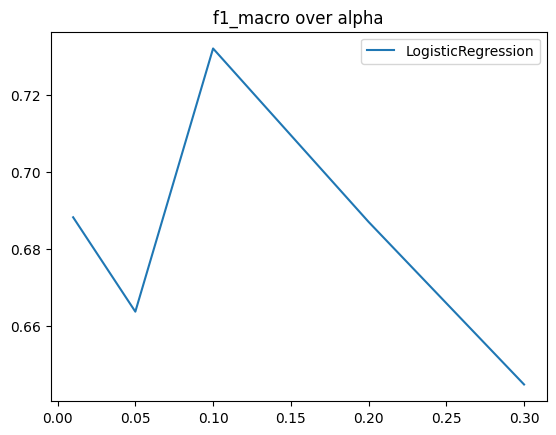

In [291]:
legend = []

for model in results_df.model.unique():
    legend.append(str(model).split("(")[0])
    plt.plot(results_df[results_df.model == model]['mean_test_score'])

plt.title(f'{score} over alpha')
plt.legend(legend)
plt.show()

## Test Set Eval

F1 score: 0.812
Accuracy: 0.833
AUC: 0.886


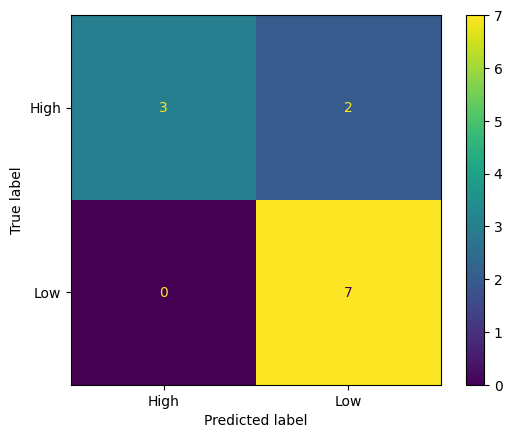

In [104]:
preds = grid.predict(X_test)
pred_proba = grid.predict_proba(X_test)

print (f'F1 score: {f1_score(y_test, preds, average="macro"):.3f}')
print (f'Accuracy: {accuracy_score(y_test, preds):.3f}')
print (f'AUC: {roc_auc_score(y_test, pred_proba[:,1]):.3f}')

conf_m = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(conf_m,display_labels=classes).plot()

In [41]:
all_glycosites_pred_proba = pred_proba[::,1]
all_glycosites_pred_proba

array([0.97603959, 0.04092955, 0.12081451, 0.9603983 , 0.01453478,
       0.98721126, 0.99999473, 0.97505838, 0.10802696, 0.3838978 ,
       0.00553032, 0.09033011])

In [94]:
glycosite_pred_proba = pred_proba[::,1]
glycosite_pred_proba

array([0.42756497, 0.38967415, 0.89868568, 0.7452158 , 0.00381584,
       0.98509656, 0.80529255, 0.94111028, 0.96639676, 0.22060115,
       0.09244938, 0.79344646])

In [125]:
glycotype_pred_proba = pred_proba[::,1]
glycotype_pred_proba

array([0.7807984 , 0.09471247, 0.37065255, 0.17124135, 0.27072197,
       0.99852659, 0.99992913, 0.70542294, 0.83786049, 0.54104636,
       0.001409  , 0.02627049])

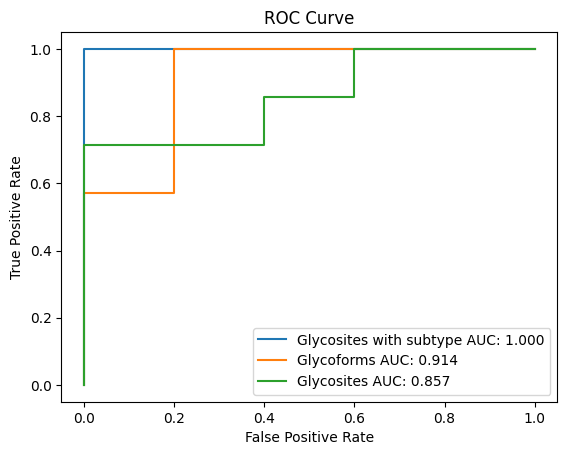

In [128]:
name = 'Glycosites with subtype'
fpr, tpr, _ = metrics.roc_curve(y_test,  glycotype_pred_proba)
auc = metrics.roc_auc_score(y_test, glycotype_pred_proba)
label = f"{name} AUC: {auc:.3f}"
plt.plot(fpr,tpr,label=label)

name = 'Glycoforms'
fpr, tpr, _ = metrics.roc_curve(y_test,  all_glycosites_pred_proba)
auc = metrics.roc_auc_score(y_test, all_glycosites_pred_proba)
label = f"{name} AUC: {auc:.3f}"
plt.plot(fpr,tpr,label=label)

name = 'Glycosites'
fpr, tpr, _ = metrics.roc_curve(y_test,  glycosite_pred_proba)
auc = metrics.roc_auc_score(y_test, glycosite_pred_proba)
label = f"{name} AUC: {auc:.3f}"
plt.plot(fpr,tpr,label=label)

plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=4)
plt.show()

## SHAP-based Importance

In [127]:
grid.best_estimator_

Pipeline(steps=[('select_fdr',
                 SelectPercentile(percentile=0.09,
                                  score_func=<function transform_mannwhitneyu at 0x000001D33F7C1A80>)),
                ('scaling', StandardScaler()),
                ('select_features',
                 SequentialFeatureSelector(direction='backward',
                                           estimator=LogisticRegression(C=0.21,
                                                                        class_weight='balanced',
                                                                        random_state=42),
                                           scoring='roc_auc', tol=-0.001)),
                ('classify',
                 LogisticRegression(C=0.21, class_weight='balanced',
                                    random_state=42))])

In [128]:
explainer = shap.Explainer(grid.best_estimator_['classify'], grid.best_estimator_['select_features'].transform(grid.best_estimator_['reduce_dim'].transform(grid.best_estimator_['scaling'].transform(X_train))))
shap_values = explainer(grid.best_estimator_['select_features'].transform(grid.best_estimator_['reduce_dim'].transform(grid.best_estimator_['scaling'].transform(X_test))))

KeyError: 'reduce_dim'

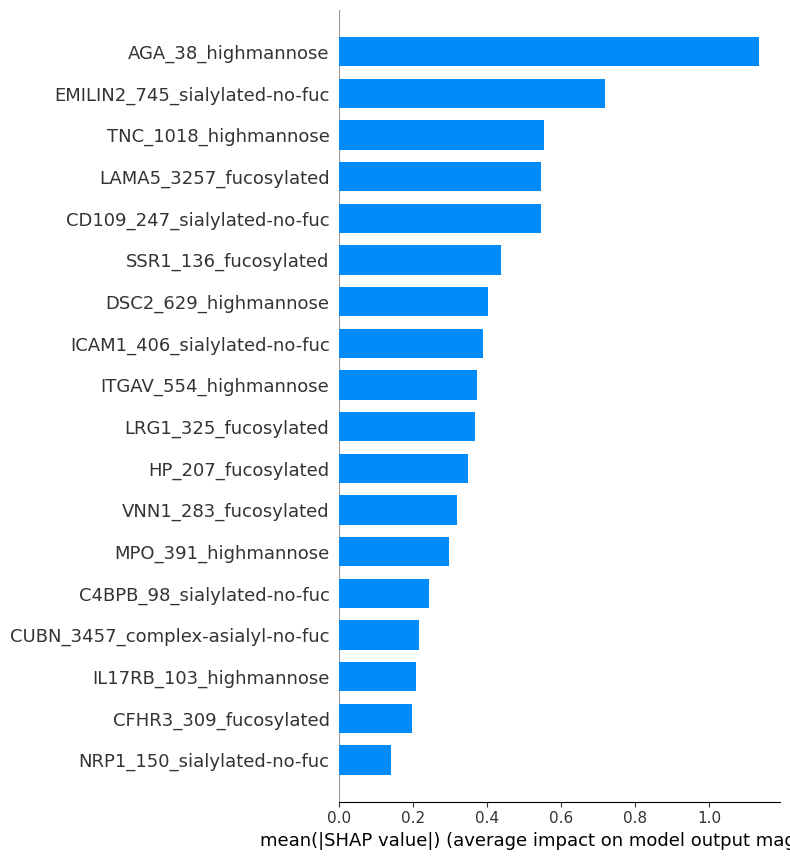

In [141]:
shap.summary_plot(shap_values, plot_type = 'bar', feature_names = grid.best_estimator_[:-1].get_feature_names_out())

In [ ]:
# https://datascience.stackexchange.com/questions/52476/how-to-use-shap-kernal-explainer-with-pipeline-models

#explainer = shap.KernelExplainer(grid.best_estimator_['classify'].predict_proba, grid.best_estimator_['reduce_dim'].transform(grid.best_estimator_['scaling'].transform(X_train)))
#shap_values = explainer.shap_values(grid.best_estimator_['reduce_dim'].transform(grid.best_estimator_['scaling'].transform(X_test)))
#shap.summary_plot(shap_values[0], plot_type='bar', feature_names=grid.best_estimator_[:-1].get_feature_names_out())

## Feature Distribution

In [236]:
CTSD_list = ["risk"]
LRP1_list = []

for i in df_model.columns:
    if "LRP1" == i.split("_")[0]:
        LRP1_list.append(i)

sorted(LRP1_list)

['LRP1_114_ELQGnCSR_N2H8F0S0G0',
 'LRP1_114_ELQGnCSR_N4H5F1S2G0',
 'LRP1_136_LGCQHHCVPTLDGPTCYCnSSFQLQADGK_N4H5F1S1G0',
 'LRP1_136_LGCQHHCVPTLDGPTCYCnSSFQLQADGK_N4H5F1S2G0',
 'LRP1_136_LGCQHHCVPTLDGPTCYCnSSFQLQADGK_N4H5F3S0G0',
 'LRP1_136_LGCQHHCVPTLDGPTCYCnSSFQLQADGK_N5H5F1S0G0',
 'LRP1_1511_WTGHnVTVVQR_N2H8F0S0G0',
 'LRP1_1511_WTGHnVTVVQR_N2H9F0S0G0',
 'LRP1_1511_WTGHnVTVVQR_N3H4F1S0G0',
 'LRP1_1511_WTGHnVTVVQR_N4H5F0S1G0',
 'LRP1_1511_WTGHnVTVVQR_N4H5F1S0G0',
 'LRP1_1511_WTGHnVTVVQR_N4H5F1S1G0',
 'LRP1_1511_WTGHnVTVVQR_N4H5F2S0G0',
 'LRP1_1511_WTGHnVTVVQR_N5H3F1S0G0',
 'LRP1_1511_WTGHnVTVVQR_N5H4F1S0G0',
 'LRP1_1511_WTGHnVTVVQR_N5H5F1S0G0',
 'LRP1_1511_WTGHnVTVVQR_N5H6F1S0G0',
 'LRP1_1575_DnTTCYEFKK_N2H9F0S0G0',
 'LRP1_1575_DnTTCYEFK_N2H5F0S0G0',
 'LRP1_1575_DnTTCYEFK_N2H7F0S0G0',
 'LRP1_1575_DnTTCYEFK_N2H8F0S0G0',
 'LRP1_1575_DnTTCYEFK_N2H9F0S0G0',
 'LRP1_1575_DnTTCYEFK_N3H4F1S1G0',
 'LRP1_1575_DnTTCYEFK_N3H5F0S1G0',
 'LRP1_1575_DnTTCYEFK_N3H5F1S1G0',
 'LRP1_1575_DnTTCYEFK_N3H6F0S0

In [243]:
CTSD_list = ["risk"]

for i in df_model.columns:
    if "LRP1" == i.split("_")[0]:
        CTSD_list.append(i)

CTSD_df = df_model[CTSD_list]
CTSD_df.columns

plot_glycoform_df = {'risk':[],'Abundance':[], 'Type':[]}

for i in CTSD_df.columns[1:]:
    for j in CTSD_df[i].to_list():
        plot_glycoform_df['Abundance'].append(j)
        plot_glycoform_df['Type'].append("LRP1")
    for h in CTSD_df['risk'].to_list():
        plot_glycoform_df['risk'].append(h)
    

In [244]:
CTSD_list = ["risk"]

for i in df_model.columns:
    if "LRP1_1645_" in i:
        CTSD_list.append(i)

CTSD_df = df_model[CTSD_list]
CTSD_df.columns

for i in CTSD_df.columns[1:]:
    for j in CTSD_df[i].to_list():
        plot_glycoform_df['Abundance'].append(j)
        plot_glycoform_df['Type'].append("LRP1_1645")
    for h in CTSD_df['risk'].to_list():
        plot_glycoform_df['risk'].append(h)
    

In [222]:

for i in CTSD_df.columns[1:]:
    for j in CTSD_df[i].to_list():
        plot_glycoform_df['Abundance'].append(j)
        if "F0" not in i.split("_")[-1]:
            plot_glycoform_df['Type'].append("CTSD_263_fucosylated")
        elif "S0" not in i.split("_")[-1]:
            plot_glycoform_df['Type'].append("CTSD_263_sialylated")
        else:
            if "N2" in i.split("_")[-1]:
                plot_glycoform_df['Type'].append("CTSD_263_highmannose")
            else: 
                plot_glycoform_df['Type'].append("CTSD_263_complex")

        #elif i.split("_")[-1] in ["N2H9F0S0G0","N2H8F0S0G0","N2H7F0S0G0","N2H6F0S0G0","N2H5F0S0G0"]:
        #    plot_glycoform_df['Type'].append("highmannose")
        #else:
        #    plot_glycoform_df['Type'].append("Other")
    for h in CTSD_df['risk'].to_list():
        plot_glycoform_df['risk'].append(h)

In [245]:
CTSD_list = ["risk"]

for i in df_model.columns:
    if "LRP1_1645_AFInGTGVETVVSADLPNAHGLAVDWVSR_N4H5F0S0G0" in i:
        CTSD_list.append(i)

CTSD_df = df_model[CTSD_list]
CTSD_df.columns

for i in CTSD_df.columns[1:]:
    for j in CTSD_df[i].to_list():
        plot_glycoform_df['Abundance'].append(j)
        plot_glycoform_df['Type'].append("LRP1_1645_N4H5F0S0G0")
    for h in CTSD_df['risk'].to_list():
        plot_glycoform_df['risk'].append(h)


In [224]:
CTSD_list = ["risk"]

for i in df_model.columns:
    if "CTSD_263_GSLSYLnVTR_N2H6F0S0G0" in i:
        CTSD_list.append(i)

CTSD_df = df_model[CTSD_list]
CTSD_df.columns

for i in CTSD_df.columns[1:]:
    for j in CTSD_df[i].to_list():
        plot_glycoform_df['Abundance'].append(j)
        plot_glycoform_df['Type'].append("CTSD_263_N2H6F0S0G0")
    for h in CTSD_df['risk'].to_list():
        plot_glycoform_df['risk'].append(h)

In [225]:
CTSD_list = ["risk"]

for i in df_model.columns:
    if "CTSD_263_GSLSYLnVTR_N2H7F0S0G0" in i:
        CTSD_list.append(i)

CTSD_df = df_model[CTSD_list]
CTSD_df.columns

for i in CTSD_df.columns[1:]:
    for j in CTSD_df[i].to_list():
        plot_glycoform_df['Abundance'].append(j)
        plot_glycoform_df['Type'].append("CTSD_263_N2H7F0S0G0")
    for h in CTSD_df['risk'].to_list():
        plot_glycoform_df['risk'].append(h)

In [226]:
CTSD_list = ["risk"]

for i in df_model.columns:
    if "CTSD_263_GSLSYLnVTR_N2H8F0S0G0" in i:
        CTSD_list.append(i)

CTSD_df = df_model[CTSD_list]
CTSD_df.columns

for i in CTSD_df.columns[1:]:
    for j in CTSD_df[i].to_list():
        plot_glycoform_df['Abundance'].append(j)
        plot_glycoform_df['Type'].append("CTSD_263_N2H8F0S0G0")
    for h in CTSD_df['risk'].to_list():
        plot_glycoform_df['risk'].append(h)

In [227]:
CTSD_list = ["risk"]

for i in df_model.columns:
    if "CTSD_263_GSLSYLnVTR_N2H9F0S0G0" in i:
        CTSD_list.append(i)

CTSD_df = df_model[CTSD_list]
CTSD_df.columns

for i in CTSD_df.columns[1:]:
    for j in CTSD_df[i].to_list():
        plot_glycoform_df['Abundance'].append(j)
        plot_glycoform_df['Type'].append("CTSD_263_N2H9F0S0G0")
    for h in CTSD_df['risk'].to_list():
        plot_glycoform_df['risk'].append(h)

In [246]:
plot_glycoform_df_combined = pd.DataFrame(plot_glycoform_df)#.sort_values(by="Type")
#plot_glycoform_df_combined = plot_glycoform_df_combined[plot_glycoform_df_combined['Type']!='CTSD_263_fucosylated']
#plot_glycoform_df_combined = plot_glycoform_df_combined[plot_glycoform_df_combined['Type']!='CTSD_263_sialylated']
#plot_glycoform_df_combined = plot_glycoform_df_combined[plot_glycoform_df_combined['Type']!='CTSD_263_complex']
#plot_glycoform_df_combined = plot_glycoform_df_combined[plot_glycoform_df_combined['Type']!='CTSD']
#plot_glycoform_df_combined = plot_glycoform_df_combined[plot_glycoform_df_combined['Type']!='CTSD_263']
#plot_glycoform_df_combined = plot_glycoform_df_combined[plot_glycoform_df_combined['Type']!='CTSD_263_highmannose']




In [247]:
from scipy import stats

data = []

for type in plot_glycoform_df_combined['Type'].unique():
    data.append(plot_glycoform_df_combined[(plot_glycoform_df_combined["risk"]=="Low") & (plot_glycoform_df_combined["Type"]==type)]["Abundance"])
    data.append(plot_glycoform_df_combined[(plot_glycoform_df_combined["risk"]=="High") & (plot_glycoform_df_combined["Type"]==type)]["Abundance"])

    # Initialise a list of combinations of groups that are significantly different
significant_combinations = []
    # Check from the outside pairs of boxes inwards
ls = list(range(1, len(data) + 1))
combinations = [(ls[x], ls[x + y]) for y in reversed(ls) for x in range((len(ls) - y))]

stats_list = []
count = 1
for i in range(len(plot_glycoform_df_combined['Type'].unique())):
    tup = (count,count+1)
    stats_list.append(tup)
    count += 2

for combination in combinations:
    data1 = data[combination[0] - 1]
    data2 = data[combination[1] - 1]
    # Significance
    U, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    if p < 0.05 and combination in stats_list:
        significant_combinations.append([combination, p])

print (significant_combinations)

[[(1, 2), 6.142067911757842e-18], [(3, 4), 5.2469052340003e-07], [(5, 6), 5.244579454574958e-06]]


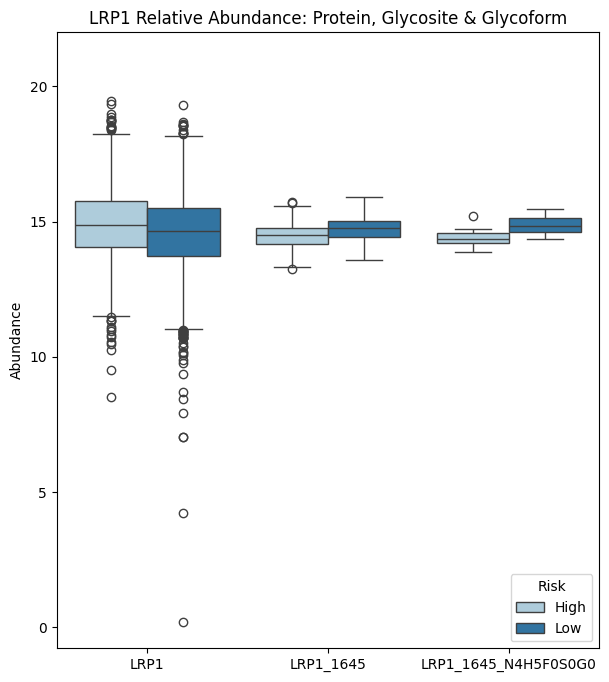

In [251]:
fig, ax = plt.subplots(figsize=(7, 8))
sns.boxplot(data=plot_glycoform_df_combined, hue="risk", x="Type", y="Abundance",palette="Paired")

plt.title("LRP1 Relative Abundance: Protein, Glycosite & Glycoform")
plt.xlabel("")
plt.legend(loc="lower right",title="Risk")
plt.ylim(top=22)
plt.xticks(rotation=0)
        
plt.show()